In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# creating rectified image for camera views
cvFile = cv2.FileStorage( "./configs/stereo_map.xml", cv2.FILE_STORAGE_READ )
ltStereoMapX = cvFile.getNode("LTStereoMapX").mat()
ltStereoMapY = cvFile.getNode("LTStereoMapY").mat()
rtStereoMapX = cvFile.getNode("RTStereoMapX").mat()
rtStereoMapY = cvFile.getNode("RTStereoMapY").mat()
cvFile.release()

In [13]:
imgL = cv2.imread( "./test_images/lt_0.png" )
imgLFixed = cv2.remap( imgL, ltStereoMapX, ltStereoMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0 )
imgR = cv2.imread( "./test_images/rt_0.png" )
imgRFixed = cv2.remap( imgR, rtStereoMapX, rtStereoMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0 )

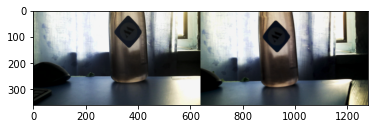

In [14]:
visual = np.concatenate( (imgL, imgR), axis=1 )
plt.imshow(visual)

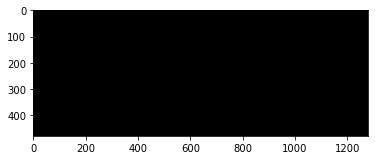

In [15]:
visual_fixed = np.concatenate(( imgLFixed, imgRFixed ), axis=1)
plt.imshow( visual_fixed )

In [6]:
stereo = cv2.StereoBM_create( numDisparities=16, blockSize=15 )
imgL = cv2.cvtColor(imgLFixed, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(imgRFixed, cv2.COLOR_BGR2GRAY)

In [7]:
stereo.setNumDisparities(16)
stereo.setBlockSize(15)
stereo.setPreFilterType(1)
stereo.setPreFilterSize(25) #2 - 25
stereo.setPreFilterCap(32)  #5 - 62
stereo.setTextureThreshold(60) #10 - 100
stereo.setUniquenessRatio(15)  #15 - 100
stereo.setSpeckleRange(50)     #0 - 100
stereo.setSpeckleWindowSize(12)#3 - 25
stereo.setDisp12MaxDiff(15)    #5 - 25
stereo.setMinDisparity(25)     #5 - 25

In [8]:
disparity = stereo.compute( imgL, imgR )

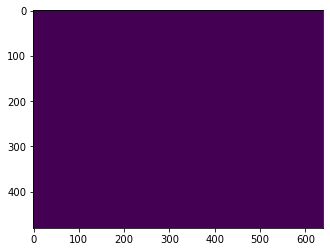

In [9]:
plt.imshow( disparity )
plt.show()

TypeError: Image data of dtype object cannot be converted to float

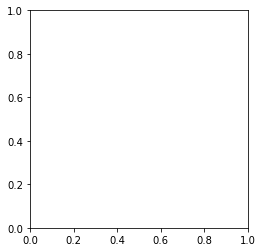

In [10]:
globalMap = cv2.imread( "./upload_dir/b3898d0e-ea1c-434b-b9b5-f354cead4217.jpg" )
plt.imshow( globalMap )

In [ ]:
gray = cv2.cvtColor( globalMap, cv2.COLOR_BGR2GRAY )
plt.imshow(gray)

In [ ]:
# detect circles
gray_blured = cv2.blur( gray, (3, 3) )
plt.imshow( gray_blured )

In [ ]:
obstacles = []
index     = 0
import numpy as np
detected_circles = cv2.HoughCircles( gray_blured, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=1, maxRadius=40 )
if detected_circles is not None:
    detected_circles = np.uint16( np.around( detected_circles ) )
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        pos = (a, b)
        
        # border outline
        cv2.circle( globalMap, center=(a, b), radius=r, color=( 0, 0, 0 ), thickness=1 )
        obstacles.append( {
            "x" : a,
            "y" : b,
            "r" : r
        } )
        
        # create labels
        cv2.putText(globalMap, text=str(index), org=(a,b),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
            thickness=2, lineType=cv2.LINE_AA)
        
        index+=1

## Show Map

In [ ]:
# show cirlces tracking
plt.imshow( globalMap )

In [ ]:
import pandas as pd
df = pd.DataFrame( obstacles )
df

In [ ]:
print( obstacles[0] )

In [ ]:
def get_coordinate( index ):
    try:
        return obstacles[ index ]
    except IndexError:
        return {}

In [ ]:
coord = get_coordinate(2)
print( coord )

In [ ]:
start = get_coordinate(0)
end   = get_coordinate(36)

In [ ]:
print(start, end)

## Meshgrid

In [ ]:
shape = np.shape( globalMap )
shape

In [ ]:
x = np.arange( -10, 10, 1 )
y = np.arange( -10, 10, 1 )

In [ ]:
x, y

In [ ]:
X, Y = np.meshgrid( x, y )

In [ ]:
deltax= np.zeros_like(X)
deltay= np.zeros_like(Y)
s = 7
r = 1

In [ ]:
for i in range( len(x) ):
    for j in range( len(y) ):
        d = np.sqrt( X[i][j]**2 + Y[i][j]**2 )
        #print(f"{i} and {y}")
        theta = np.arctan2( Y[i][j], X[i][j] )
        
        # repulsive formular
        if d < 2:
            deltax[i][j] = np.sign( np.cos( theta ) )
            deltay[i][j] = np.sign( np.cos( theta ) )
        elif d > r + s:
            deltax[i][j] = 0
            deltay[i][j] = 0
        else:
            deltax[i][j] = 50 * ( s + r - d ) * np.cos( theta )
            deltay[i][j] = 50 * ( s + r - d ) * np.sin( theta )

In [ ]:
fig, ax = plt.subplots( figsize=(50, 50) )
ax.quiver( X, Y, deltax, deltay )
ax.add_patch( plt.Circle( ( 0, 0 ), 2, color='m' ) )
ax.annotate('Obj', xy=(0, 0), fontsize=20, ha='center')
plt.show()

In [ ]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

# Parameters
KP = 5.0  # attractive potential gain
ETA = 100.0  # repulsive potential gain
AREA_WIDTH = 30.0  # potential area width [m]
# the number of previous positions used to check oscillations
OSCILLATIONS_DETECTION_LENGTH = 3

show_animation = True


def calc_potential_field(gx, gy, ox, oy, reso, rr, sx, sy):
    minx = min(min(ox), sx, gx) - AREA_WIDTH / 2.0
    miny = min(min(oy), sy, gy) - AREA_WIDTH / 2.0
    maxx = max(max(ox), sx, gx) + AREA_WIDTH / 2.0
    maxy = max(max(oy), sy, gy) + AREA_WIDTH / 2.0
    xw = int(round((maxx - minx) / reso))
    yw = int(round((maxy - miny) / reso))

    # calc each potential
    pmap = [[0.0 for i in range(yw)] for i in range(xw)]

    for ix in range(xw):
        x = ix * reso + minx

        for iy in range(yw):
            y = iy * reso + miny
            ug = calc_attractive_potential(x, y, gx, gy)
            uo = calc_repulsive_potential(x, y, ox, oy, rr)
            uf = ug + uo
            pmap[ix][iy] = uf

    return pmap, minx, miny


def calc_attractive_potential(x, y, gx, gy):
    return 0.5 * KP * np.hypot(x - gx, y - gy)


def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= 0.1:
            dq = 0.1

        return 0.5 * ETA * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0


def get_motion_model():
    # dx, dy
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False


def potential_field_planning(sx, sy, gx, gy, ox, oy, reso, rr):

    # calc potential field
    pmap, minx, miny = calc_potential_field(gx, gy, ox, oy, reso, rr, sx, sy)

    # search path
    d = np.hypot(sx - gx, sy - gy)
    ix = round((sx - minx) / reso)
    iy = round((sy - miny) / reso)
    gix = round((gx - minx) / reso)
    giy = round((gy - miny) / reso)

    if show_animation:
        draw_heatmap(pmap)
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(ix, iy, "*k")
        plt.plot(gix, giy, "*m")

    rx, ry = [sx], [sy]
    motion = get_motion_model()
    previous_ids = deque()

    while d >= reso:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if inx >= len(pmap) or iny >= len(pmap[0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                print("outside potential!")
            else:
                p = pmap[inx][iny]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso + minx
        yp = iy * reso + miny
        d = np.hypot(gx - xp, gy - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break

        if show_animation:
            plt.plot(ix, iy, ".r")
            plt.pause(0.01)

    print("Goal!!")

    return rx, ry


def draw_heatmap(data):
    data = np.array(data).T
    plt.pcolor(data, vmax=100.0, cmap=plt.cm.Blues)


def main():
    print("potential_field_planning start")

    sx = 0.0  # start x position [m]
    sy = 10.0  # start y positon [m]
    gx = 30.0  # goal x position [m]
    gy = 30.0  # goal y position [m]
    grid_size = 0.5  # potential grid size [m]
    robot_radius = 5.0  # robot radius [m]

    ox = [15.0, 5.0, 20.0, 25.0]  # obstacle x position list [m]
    oy = [25.0, 15.0, 26.0, 25.0]  # obstacle y position list [m]

    if show_animation:
        plt.grid(True)
        plt.axis("equal")

    # path generation
    _, _ = potential_field_planning(
        sx, sy, gx, gy, ox, oy, grid_size, robot_radius)

    if show_animation:
        plt.show()


if __name__ == '__main__':
    main()